In [1]:
import json
import logging

import numpy as np

from pathlib import Path

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

Setting up Logger

In [2]:
# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

Loading the `ConfigParser` for paths

In [3]:
from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

In [4]:
# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading the Meta Donor DataFrame

In [5]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."


Converting the gene_expression_values from a stored string to a list

In [6]:
meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


### Thresholding over the Sample Sizes

In [7]:
meta_donor_df_filtered = meta_donor_df.copy()
number_of_samples_per_br_ge = get_number_of_samples_per_br_ge(meta_donor_df_filtered)
logger.info(f"{meta_donor_df_filtered.head(3)}")
range_with_powers_of_two = [2**i for i in range(3, 11)] 
count_per_threshold= get_br_ge_count_above_sample_size(meta_donor_df_filtered, range = range_with_powers_of_two)

   brain_region  gene_id                             gene_expression_values  \
0          4012        2  [1.58747780630413, 7.567907786636231, 1.495682...   
1          4012        3  [5.11909080343638, 9.66921569197332, 10.081154...   
2          4012        6  [1.83564765363665, 1.4949501777457102, 5.94151...   

   sample_count  
0            22  
1            44  
2            77  


In [8]:
meta_donor_df_filtered = mask_samples_threshold(meta_donor_df_filtered, threshold=1024)
logger.info(meta_donor_df_filtered.head(4))
logger.info(f"DF Length after filtering matches number of samples expected: {count_per_threshold[len(count_per_threshold)-1]==len(meta_donor_df_filtered)}")

       brain_region  gene_id  \
1692           4012     2541   
30067          4013     1259   
30871          4013     2541   
59246          4014     1259   

                                  gene_expression_values  sample_count  
1692   [3.4665720939923, 6.68308773283322, 8.86049794...          1232  
30067  [3.98176589692518, 7.197362738781371, 7.085808...          1691  
30871  [3.77584458705954, 6.82958903428939, 8.7794863...          2128  
59246  [3.9620965408367206, 6.32327474953542, 6.56900...          1602  
DF Length after filtering matches number of samples expected: True


### Calculating H0 expression values

In [9]:
geneid_H0 = calculate_gene_mean_expression_values(meta_donor_df)

logger.info(geneid_H0.head(5))
logger.info(f"Number of Total Sample Count == {geneid_H0['total_sample_count'].sum() == get_total_number_of_samples(meta_donor_df)}")

   gene_id  total_expression  total_sample_count  weighted_mean
0        2      16227.834876                3936       4.122926
1        3      66283.660534                7872       8.420180
2        6      41203.873837               13776       2.990990
3        7      19101.630752                3936       4.853057
4        9      21518.755199                7872       2.733582
Number of Total Sample Count == True


Histogram of Mean Expression Values per Gene

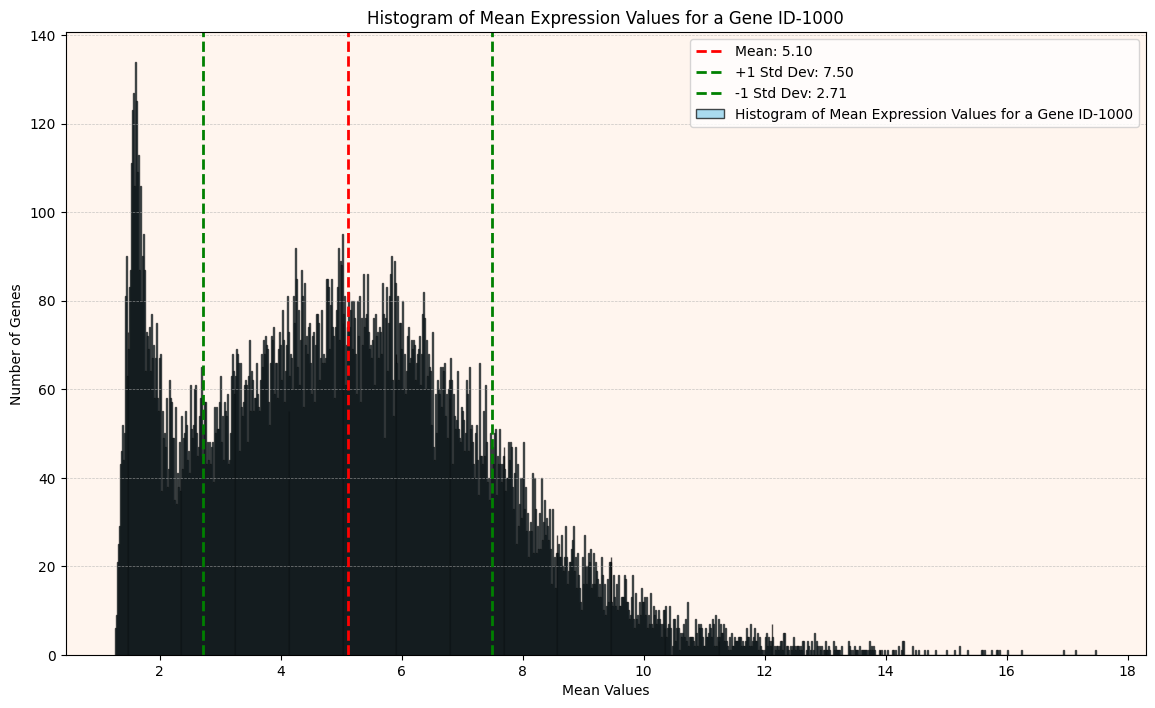

In [10]:
plot_histogram(geneid_H0["weighted_mean"], plot_title="Histogram of Mean Expression Values for a Gene ID-1000", 
               x_title="Mean Values", y_title="Number of Genes", bins=1000, save=True)

In [11]:
len(meta_donor_df[(meta_donor_df['brain_region'] == 4012) & (meta_donor_df['gene_id'] == 2541)]["gene_expression_values"].to_list()[0])

1232

### Calculating STD of each Gene ID for Calculating the Effect Sizes

In [12]:
df_std = meta_donor_df.copy()
std_per_gene = calculate_std_gene_id_optimized(df_std)
geneid_H0["std"] = std_per_gene["std"]
geneid_H0

,gene_id,total_expression,total_sample_count,weighted_mean,std
0,2,16227.834876,3936,4.122926,2.693218
1,3,66283.660534,7872,8.420180,2.464688
2,6,41203.873837,13776,2.990990,2.067025
3,7,19101.630752,3936,4.853057,3.455754
4,9,21518.755199,7872,2.733582,1.433369
...,...,...,...,...,...
29174,1021983,23070.153990,1968,11.722639,0.659900
29175,1021987,14015.323388,1968,7.121607,1.285315
29176,1022208,6114.516142,1968,3.106970,0.936846
29177,1022393,25574.523712,3936,6.497592,1.040899


In [15]:
# Extract the values for one of the groups
sample_size = 64
gene_id = 2541

sample = get_br_ge_sample(meta_donor_df_filtered, br=4012, ge=gene_id)
print(len(sample))

if sample_size > len(sample):
    logger.warning(f"Reproducing Error, sample size available: {len(sample)} < sample_size chosen: {sample_size}")
else:
    sample = sample[:sample_size]


sample_mean = np.mean(sample)

1232


### Calculating Effect Size Cohen's D and Power Analysis
Calculating std per Gene_id 

In [16]:
control_group_mean = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "weighted_mean"].iloc[0]
control_group_std = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "std"].iloc[0]
control_group_size = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "total_sample_count"].iloc[0]

effect_size = calculate_cohen_d(sample_mean=np.mean(sample), control_group_mean=control_group_mean,
                  sample_std=np.std(sample), control_group_std=control_group_std,
                  sample_length=len(sample), control_group_length=control_group_size)


power = calculate_test_power(effect_size, np.mean(sample), control_group_mean, np.std(sample), len(sample))

logger.info(f"Effect Size Calculated: {effect_size}")
logger.info(f"Power Calculated: {power}")

Effect Size Calculated: 0.2501286171739975
Power Calculated: 1.0


### Student's One Sample T Test

In [42]:
from scipy.stats import ttest_1samp
import numpy as np


# Specify the value to compare against (e.g., the mean of another group)
control_group_mean = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "weighted_mean"].iloc[0]

# Perform bootstraping to calculate p-value
B = 10000
t_obs_stat = calculate_t_statistic(np.mean(sample), np.std(sample), len(sample), control_group_mean)
p_value, bootstraped_samples = calculate_bootstrap_p_value(sample, t_obs_stat, B, control_group_mean) 

# Display the results
print(f"T-statistic: {t_obs_stat}")
print(f"P-value: {p_value}")

# Compare the mean directly
print(f"Sample Mean: {control_group_mean}")
print(f"Control Group Mean: {control_group_mean}")


T-statistic: 9.128628395957993
P-value: 0.53
Sample Mean: 5.372713819741972
Control Group Mean: 5.372713819741972


Visualizing the Comparison:

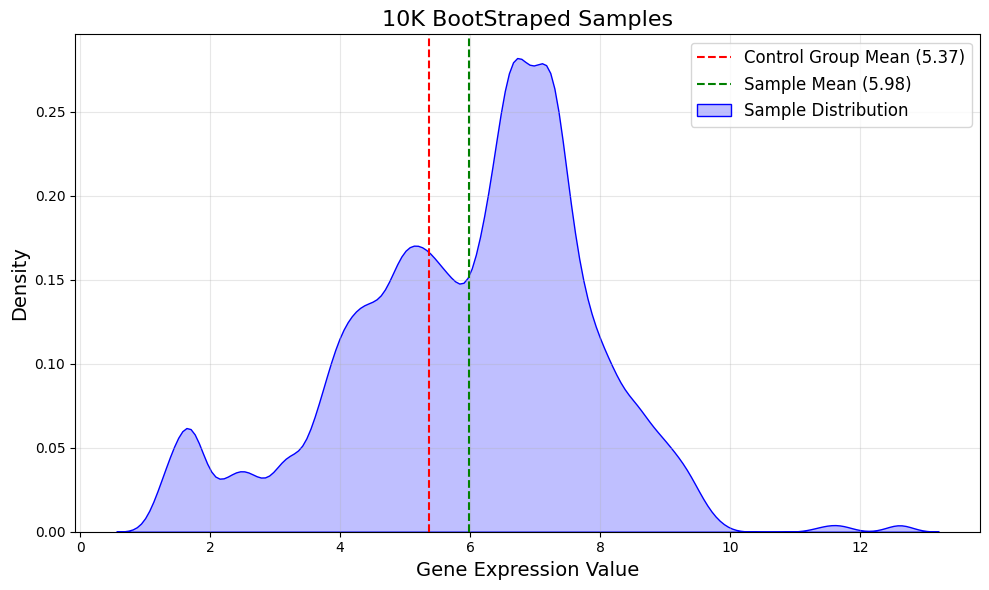

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(bootstraped_samples, label='Sample Distribution', shade=True, color='blue', bw_adjust=0.5)

# Add a vertical line for the group 3 mean
plt.axvline(control_group_mean, color='red', linestyle='--', label=f'Control Group Mean ({control_group_mean:.2f})')
plt.axvline(np.mean(bootstraped_samples), color='green', linestyle='--', label=f'Sample Mean ({np.mean(bootstraped_samples):.2f})')

# Add labels and legend
plt.title('10K BootStraped Samples', fontsize=16)
plt.xlabel('Gene Expression Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()
